In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from models import LinearAutoEncoder, ConvAutoEncoder, BaselineClassifier, LinearClassifier, JointModel
from sklearn.metrics import f1_score

## Dataset Loading

In [2]:
import json, gzip

class MNIST_Dataset(Dataset):
    def __init__(self, json_data) -> None:
        self.features = [torch.FloatTensor(i['image']).view(28,28) for i in json_data]
        self.labels = [torch.LongTensor([i['label']]) for i in json_data]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = None
dev_dataset = None
test_dataset = None

with gzip.open('mnist_rowmajor.jsonl.gz') as file:
    trainval_data = []
    test_data = []

    for sample in [json.loads(line) for line in file]:
        sample['image'] = sample['image']
        if sample['split'] == 'train':
            trainval_data.append(sample)
        else:
            test_data.append(sample)

    train_dataset = MNIST_Dataset(trainval_data[:50000])
    dev_dataset = MNIST_Dataset(trainval_data[50000:])
    test_dataset = MNIST_Dataset(test_data)

In [3]:
BATCH_SIZE = 100

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Question 2b

### Training Function

In [4]:
def train_encoder(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, max_epoch = 1):
    # stats for matplot
    loss_train = []
    loss_eval = []
    # epoch loop
    for epoch in range(max_epoch):
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, _ in dev_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # update statistics
            total_loss += criterion(pred_x, x).item()
            total_num += 1
        loss_eval.append(total_loss/total_num)
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, _ in train_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # calculate gradients
            loss = criterion(pred_x, x)
            loss.backward()
            # update statistics
            total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        loss_train.append(total_loss/total_num)
        # 
        # check convergence
        # 
        if epoch > 0 and abs(loss_train[epoch] - loss_train[epoch - 1]) < 0.005:
            break
    epochs = len(loss_train)
    plt.plot([i for i in range(epochs)], loss_train, color='r', label='Train')
    plt.plot([i for i in range(epochs)], loss_eval, color='b', label='Dev')
    plt.title(f'Avg Loss\nConverged at {loss_eval[epochs-1]:.4f} (dev set) after {epochs} epochs')
    plt.ylabel('avg loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

### Training

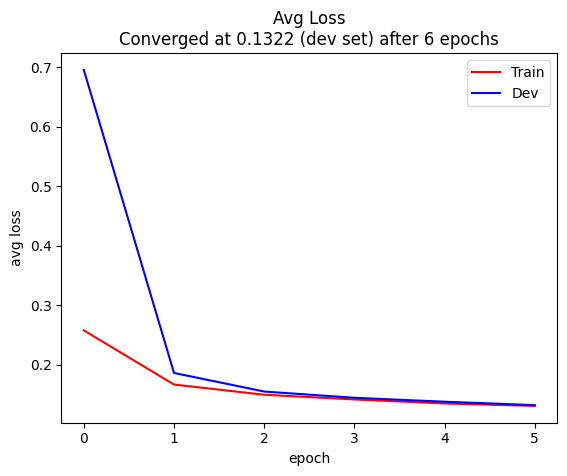

In [5]:
encoder_linear = LinearAutoEncoder().cuda()
train_encoder(encoder_linear, nn.BCELoss(), optim.Adam(encoder_linear.parameters(), lr=0.001), 100)

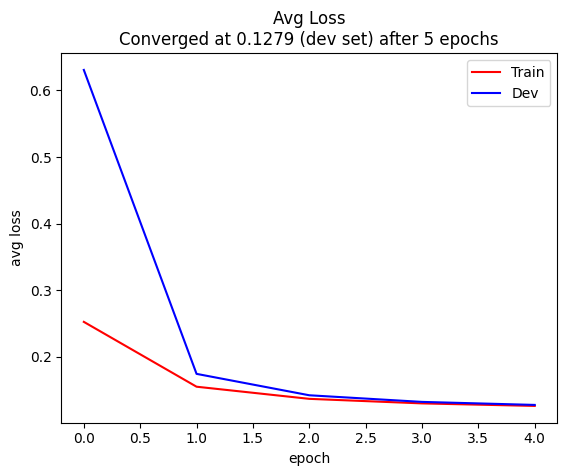

In [6]:
encoder_conv = ConvAutoEncoder().cuda()
train_encoder(encoder_conv, nn.BCELoss(), optim.Adam(encoder_conv.parameters(), lr=0.001), 100)

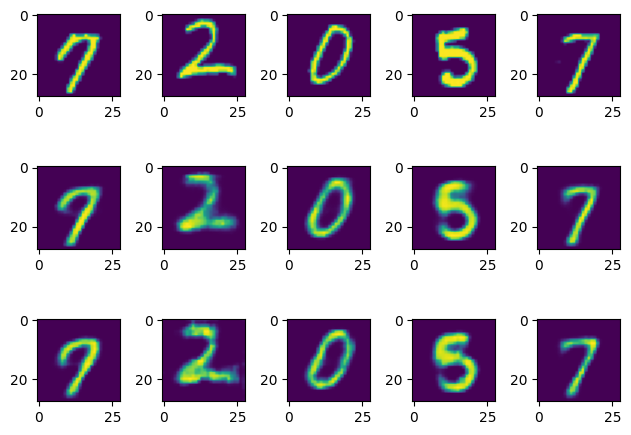

In [7]:
import random
fig, (row1, row2, row3) = plt.subplots(3, 5)

for i in range(5):
    x = dev_dataset[random.randint(0,10000-1)][0].cuda()
    x_pred_linear = encoder_linear.forward(x, detach=True).view(28,28)
    x_pred_conv = encoder_conv.forward(x, detach=True).view(28,28)

    row1[i].imshow(x.cpu())
    row2[i].imshow(x_pred_linear.cpu())
    row3[i].imshow(x_pred_conv.cpu())

plt.tight_layout()
plt.show()

## Question 2c

### Training Functions

In [8]:
def train_baseline(model: BaselineClassifier, criterion: nn.Module, num_epoch = 1):
    # stats for matplot
    loss_train = []
    loss_eval = []
    # epoch loop
    for epoch in range(num_epoch):
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        loss_eval.append(total_loss/total_num)
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
            # backward pass
            for y_i in y:
                model.w[y_i] += 1
        loss_train.append(total_loss/total_num)
        # 
        # check convergence
        # 
        if epoch > 0 and abs(loss_train[epoch] - loss_train[epoch - 1]) < 0.008:
            break
    epochs = len(loss_train)
    plt.plot([i for i in range(epochs)], loss_train, color='r', label='Train')
    plt.plot([i for i in range(epochs)], loss_eval, color='b', label='Test')
    plt.title(f'Avg Loss\nConverged at {loss_eval[epochs-1]:.4f} (test set) after {epochs} epochs')
    plt.ylabel('avg loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [9]:
def train_classifier(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer,
                     encoder: nn.Module, max_epoch = 1):
    # stats for matplot
    loss_train = []
    loss_eval = []
    # epoch loop
    for epoch in range(max_epoch):
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            z = encoder.forward(x).detach()
            pred_y = model.forward(z)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        loss_eval.append(total_loss/total_num)
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            z = encoder.forward(x).detach()
            pred_y = model.forward(z)
            # calculate gradients
            loss = criterion(pred_y, y)
            loss.backward()
            # update statistics
            total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        loss_train.append(total_loss/total_num)
        # 
        # check convergence
        # 
        if epoch > 0 and abs(loss_train[epoch] - loss_train[epoch - 1]) < 0.008:
            break
    epochs = len(loss_train)
    plt.plot([i for i in range(epochs)], loss_train, color='r', label='Train')
    plt.plot([i for i in range(epochs)], loss_eval, color='b', label='Test')
    plt.title(f'Avg Loss\nConverged at {loss_eval[epochs-1]:.4f} (test set) after {epochs} epochs')
    plt.ylabel('avg loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

### Training

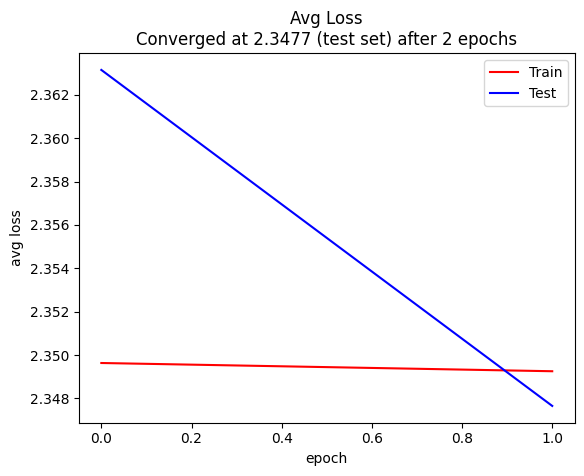

In [10]:
classifier_base = BaselineClassifier().cuda()
train_baseline(classifier_base, nn.CrossEntropyLoss(), 100)

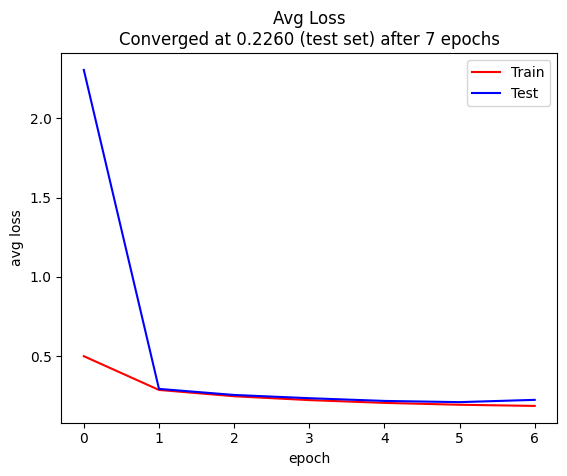

In [11]:
classifier_linear = LinearClassifier().cuda()
train_classifier(classifier_linear, nn.CrossEntropyLoss(), optim.Adam(classifier_linear.parameters(), lr=0.001),
                 encoder_conv, 100)

## Question 3

### Training Function

In [12]:
def joint_training(model: JointModel, criterion: nn.Module, crit_encoder: nn.Module, optimizer: optim.Optimizer, max_epoch = 1):
    # stats for matplot
    loss_train = []
    loss_eval = []
    # epoch loop
    for epoch in range(max_epoch):
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        loss_eval.append(total_loss/total_num)
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            z = model.autoencoder.forward(x)
            pred_y = model.classifier.forward(z)
            # calculate gradients
            classifier_loss = criterion(pred_y, y)
            encoder_loss = crit_encoder(z, x)
            loss = classifier_loss + encoder_loss
            loss.backward()
            # update statistics
            total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        loss_train.append(total_loss/total_num)
        # 
        # check convergence
        # 
        if epoch > 0 and abs(loss_train[epoch] - loss_train[epoch - 1]) < 0.005:
            break
    epochs = len(loss_train)
    plt.plot([i for i in range(epochs)], loss_train, color='r', label='Train')
    plt.plot([i for i in range(epochs)], loss_eval, color='b', label='Test')
    plt.title(f'Avg Loss\nConverged at {loss_eval[epochs-1]:.4f} (test set) after {epochs} epochs')
    plt.ylabel('avg loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

### Training

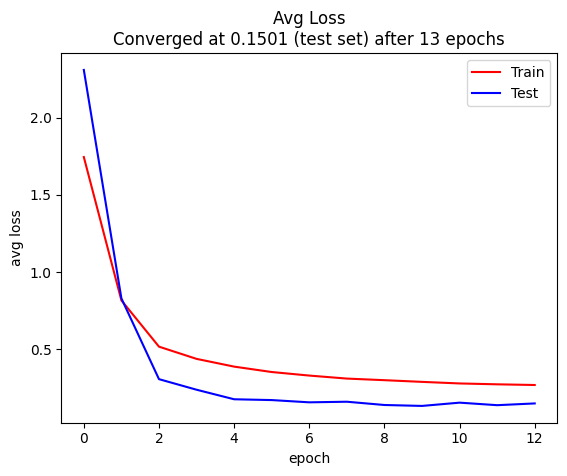

In [13]:
joint_model = JointModel().cuda()
joint_training(joint_model, nn.CrossEntropyLoss(), nn.BCELoss(), optim.Adam(joint_model.parameters(), lr=0.001), 100)

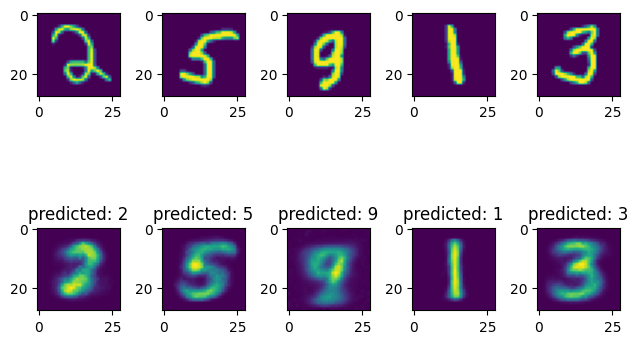

In [14]:
import random
fig, (row1, row2) = plt.subplots(2, 5)

with torch.no_grad():
    for i in range(5):
        x = dev_dataset[random.randint(0,10000-1)][0].cuda()
        z = joint_model.autoencoder.forward(x)
        y_pred = joint_model.forward(z).argmax().item()

        row1[i].imshow(x.cpu())
        row2[i].imshow(z.cpu().view(28,28))
        row2[i].set_title(f'predicted: {y_pred}')

plt.tight_layout()
plt.show()